In [16]:
import cv2
import numpy as np
import scipy.io as sio
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import sys
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

# !pip install opencv-python==3.4.2.16
# !pip install opencv-contrib-python==3.4.2.16

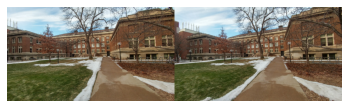

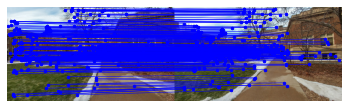

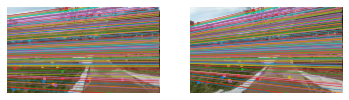

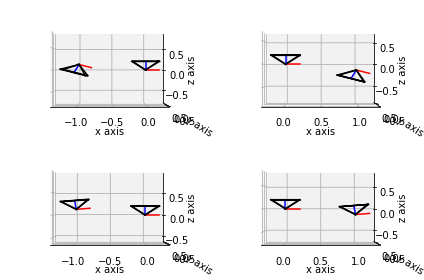

NameError: name 'triangulation' is not defined

In [17]:
# def find_match(img1, img2):
#     # TO DO
#     return pts1, pts2


# def compute_F(pts1, pts2):
#     # TO DO
#     return F


# def triangulation(P1, P2, pts1, pts2):
#     # TO DO
#     return pts3D


# def disambiguate_pose(Rs, Cs, pts3Ds):
#     # TO DO
#     return R, C, pts3D


# def compute_rectification(K, R, C):
#     # TO DO
#     return H1, H2


# def dense_match(img1, img2):
#     # TO DO
#     return disparity


# PROVIDED functions
def compute_camera_pose(F, K):
    E = K.T @ F @ K
    R_1, R_2, t = cv2.decomposeEssentialMat(E)
    # 4 cases
    R1, t1 = R_1, t
    R2, t2 = R_1, -t
    R3, t3 = R_2, t
    R4, t4 = R_2, -t

    Rs = [R1, R2, R3, R4]
    ts = [t1, t2, t3, t4]
    Cs = []
    for i in range(4):
        Cs.append(-Rs[i].T @ ts[i])
    return Rs, Cs


def visualize_img_pair(img1, img2):
    img = np.hstack((img1, img2))
    if img1.ndim == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


def visualize_find_match(img1, img2, pts1, pts2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    img_h = img1.shape[0]
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    pts1 = pts1 * scale_factor1
    pts2 = pts2 * scale_factor2
    pts2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for i in range(pts1.shape[0]):
        plt.plot([pts1[i, 0], pts2[i, 0]], [pts1[i, 1], pts2[i, 1]], 'b.-', linewidth=0.5, markersize=5)
    plt.axis('off')
    plt.show()


def visualize_epipolar_lines(F, pts1, pts2, img1, img2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    for i in range(pts1.shape[0]):
        x1, y1 = int(pts1[i][0] + 0.5), int(pts1[i][1] + 0.5)
        ax1.scatter(x1, y1, s=5)
        p1, p2 = find_epipolar_line_end_points(img2, F, (x1, y1))
        ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    for i in range(pts2.shape[0]):
        x2, y2 = int(pts2[i][0] + 0.5), int(pts2[i][1] + 0.5)
        ax2.scatter(x2, y2, s=5)
        p1, p2 = find_epipolar_line_end_points(img1, F.T, (x2, y2))
        ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    ax1.axis('off')
    ax2.axis('off')
    plt.show()


def find_epipolar_line_end_points(img, F, p):
    img_width = img.shape[1]
    el = np.dot(F, np.array([p[0], p[1], 1]).reshape(3, 1))
    p1, p2 = (0, -el[2] / el[1]), (img.shape[1], (-img_width * el[0] - el[2]) / el[1])
    _, p1, p2 = cv2.clipLine((0, 0, img.shape[1], img.shape[0]), p1, p2)
    return p1, p2


def visualize_camera_poses(Rs, Cs):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2 = Rs[i], Cs[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1)
        draw_camera(ax, R2, C2)
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
    fig.tight_layout()
    plt.show()


def visualize_camera_poses_with_pts(Rs, Cs, pts3Ds):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2, pts3D = Rs[i], Cs[i], pts3Ds[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1, 5)
        draw_camera(ax, R2, C2, 5)
        ax.plot(pts3D[:, 0], pts3D[:, 1], pts3D[:, 2], 'b.')
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
    fig.tight_layout()
    plt.show()


def draw_camera(ax, R, C, scale=0.2):
    axis_end_points = C + scale * R.T  # (3, 3)
    vertices = C + scale * R.T @ np.array([[1, 1, 1], [-1, 1, 1], [-1, -1, 1], [1, -1, 1]]).T  # (3, 4)
    vertices_ = np.hstack((vertices, vertices[:, :1]))  # (3, 5)

    # draw coordinate system of camera
    ax.plot([C[0], axis_end_points[0, 0]], [C[1], axis_end_points[1, 0]], [C[2], axis_end_points[2, 0]], 'r-')
    ax.plot([C[0], axis_end_points[0, 1]], [C[1], axis_end_points[1, 1]], [C[2], axis_end_points[2, 1]], 'g-')
    ax.plot([C[0], axis_end_points[0, 2]], [C[1], axis_end_points[1, 2]], [C[2], axis_end_points[2, 2]], 'b-')

    # draw square window and lines connecting it to camera center
    ax.plot(vertices_[0, :], vertices_[1, :], vertices_[2, :], 'k-')
    ax.plot([C[0], vertices[0, 0]], [C[1], vertices[1, 0]], [C[2], vertices[2, 0]], 'k-')
    ax.plot([C[0], vertices[0, 1]], [C[1], vertices[1, 1]], [C[2], vertices[2, 1]], 'k-')
    ax.plot([C[0], vertices[0, 2]], [C[1], vertices[1, 2]], [C[2], vertices[2, 2]], 'k-')
    ax.plot([C[0], vertices[0, 3]], [C[1], vertices[1, 3]], [C[2], vertices[2, 3]], 'k-')


def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
    y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
    z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


def visualize_disparity_map(disparity):
    plt.imshow(disparity, cmap='jet')
    plt.show()


if __name__ == '__main__':
    # read in left and right images as RGB images
    img_left = cv2.imread('left.bmp', 1)
    img_right = cv2.imread('right.bmp', 1)
    visualize_img_pair(img_left, img_right)

    # Step 1: find correspondences between image pair
    pts1, pts2 = find_match(img_left, img_right)
    visualize_find_match(img_left, img_right, pts1, pts2)

    # Step 2: compute fundamental matrix
    F = compute_F(pts1, pts2)
    visualize_epipolar_lines(F, pts1, pts2, img_left, img_right)

    # Step 3: computes four sets of camera poses
    K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
    Rs, Cs = compute_camera_pose(F, K)
    visualize_camera_poses(Rs, Cs)

    # Step 4: triangulation
    pts3Ds = []
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    for i in range(len(Rs)):
        P2 = K @ np.hstack((Rs[i], -Rs[i] @ Cs[i]))
        pts3D = triangulation(P1, P2, pts1, pts2)
        pts3Ds.append(pts3D)
    visualize_camera_poses_with_pts(Rs, Cs, pts3Ds)

    # Step 5: disambiguate camera poses
    R, C, pts3D = disambiguate_pose(Rs, Cs, pts3Ds)

    # Step 6: rectification
    H1, H2 = compute_rectification(K, R, C)
    img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
    img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
    visualize_img_pair(img_left_w, img_right_w)

    # Step 7: generate disparity map
    img_left_w = cv2.resize(img_left_w, (int(img_left_w.shape[1] / 2), int(img_left_w.shape[0] / 2)))  # resize image for speed
    img_right_w = cv2.resize(img_right_w, (int(img_right_w.shape[1] / 2), int(img_right_w.shape[0] / 2)))
    img_left_w = cv2.cvtColor(img_left_w, cv2.COLOR_BGR2GRAY)  # convert to gray scale
    img_right_w = cv2.cvtColor(img_right_w, cv2.COLOR_BGR2GRAY)
    disparity = dense_match(img_left_w, img_right_w)
    visualize_disparity_map(disparity)

    # save to mat
    sio.savemat('stereo.mat', mdict={'pts1': pts1, 'pts2': pts2, 'F': F, 'pts3D': pts3D, 'H1': H1, 'H2': H2,
                                     'img_left_w': img_left_w, 'img_right_w': img_right_w, 'disparity': disparity})


In [18]:
for i in range(4):
  print(np.count_nonzero(pts3Ds[i]))

IndexError: list index out of range

In [21]:
def find_match(img1, img2): #requires img1 and img2 to be black and white. Based off openCV official tutorial code https://docs.opencv.org/3.4.2/da/df5/tutorial_py_sift_intro.html
    sift = cv2.xfeatures2d.SIFT_create()
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    kp1 = sift.detect(img1,None)
    kp2 = sift.detect(img2,None)

    #features of the images
    I1features = sift.compute(img1, kp1)[1]
    I2features = sift.compute(img2, kp2)[1]

    #calculating nearest neighbors from I1 to I2 and from I2 to I1
    nbrs1to2 = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(I1features)
    d1to2, i1to2 = nbrs1to2.kneighbors(I2features)
    nbrs2to1 = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(I2features)
    d1to2, i2to1 = nbrs2to1.kneighbors(I1features)

    #matching process; eliminates nonmatches in a new array naive_matches
    match2to1 = np.zeros(i2to1.shape[0], dtype=bool)
    for i in range(i2to1.shape[0]):
      match2to1[i] = bool(i1to2[i2to1[i,0],0] == i) #see if point matches from 1 to 2 and from 2 to 1
    naive_matches = i2to1[match2to1]
    naive_matches_d = d1to2[match2to1]

    #ratio test; eliminates those not passing the ratio test in true_matches
    ratio_test = np.zeros(naive_matches.shape[0], dtype=bool)
    for i in range(naive_matches.shape[0]):
      ratio_test[i] = bool(naive_matches_d[i,0]/naive_matches_d[i,1] < 0.7)
    true_matches = naive_matches[ratio_test, 0]

    #key point numbers
    true_matches_1to2 = i1to2[true_matches,0]
    true_matches_2to1 = i2to1[i1to2[true_matches,0],0]

    #extract coordinates from true match key points
    x1 = np.zeros(shape=(true_matches_1to2.shape[0], 2))
    x2 = np.zeros(shape=(true_matches_1to2.shape[0], 2))
    for i in range(true_matches_1to2.shape[0]):
      x1[i] = kp1[true_matches_1to2[i]].pt
      x2[i] = kp2[true_matches_2to1[i]].pt

    return x1, x2

In [22]:
def compute_F(pts1, pts2):
    ransac_iter = 1000
    current_best_value = np.inf
    saved_transformation = np.zeros(shape = (3,3))
    u = np.append(pts1,np.ones((pts1.shape[0],1)), axis=1).T
    v = np.append(pts2,np.ones((pts2.shape[0],1)), axis=1).T

    for i in range(ransac_iter):
      rand_idxs = np.random.choice(pts2.shape[0], 8, replace=False)
      # pts = pts1[rand_idxs]  #(x,y)
      A = np.zeros((1,9))
      for idx in rand_idxs:
        A = np.append(A, np.array([ pts1[idx][0]*pts2[idx][0],
                                pts1[idx][1]*pts2[idx][0],
                                1*pts2[idx][0],
                                pts1[idx][0]*pts2[idx][1],
                                pts1[idx][1]*pts2[idx][1],
                                1*pts2[idx][1],
                                pts1[idx][0]*1,
                                pts1[idx][1]*1,
                                1*1
                                ]).reshape((1,9)), axis=0)
      A = A[1:,:]
      f = null_space(A)
      try:
        F = f.reshape(3,3)

        #calculate accuracy of 8 points
        distances = np.abs(np.sum((v * (F @ u)), axis=0))
        total_loss = np.sum(distances)

        if total_loss < current_best_value:
          current_best_value = total_loss
          # print(total_loss)
          saved_transformation = F
      except:
        1+1

    U, s, vh = np.linalg.svd(saved_transformation)
    s[2] = 0
    saved_transformation = np.matmul(U * s, vh)
    F = saved_transformation
    return F

In [23]:
def triangulation(P1, P2, pts1, pts2):
    pts3D = np.zeros((pts1.shape[0], 3))
    for i in range(pts1.shape[0]):
      ss_1 = np.array([[0, -1, pts1[i,1]],
                      [1, 0, -pts1[i,0]],
                      [-pts1[i,1], pts1[i,0], 0]])
      ss_2 = np.array([[0, -1, pts2[i,1]],
                      [1, 0, -pts2[i,0]],
                      [-pts2[i,1], pts2[i,0], 0]])

      A = np.append(ss_1 @ P1, ss_2 @ P2, axis=0)
      U, s, vh = np.linalg.svd(A)

      try:
        pts3D[i,:] = (vh[-1]/vh[-1,3])[:3]
      except:
        print("nope")

    return pts3D

In [24]:
def disambiguate_pose(Rs, Cs, pts3Ds):
    best_num_valid = 0
    for i in range(len(Rs)):
      r_3T = (Rs[i][2,:]).reshape(1,3)
      X = pts3Ds[i].T
      C = Cs[i]
      Or_3T = np.eye(3)
      OC = np.zeros((3,1))
      cur_num_valid = np.sum((r_3T @ (X-C) > 0) & (Or_3T @ (X-OC) > 0))
      print(cur_num_valid)
      if cur_num_valid > best_num_valid:
        ind = i
        best_num_valid = cur_num_valid
        R = Rs[i]
        C = Cs[i]
        pts3D = pts3Ds[i]
      print("best", best_num_valid)
    print(ind)
    return R, C, pts3D


In [25]:
  def compute_rectification(K, R, C):
    r_z_tilde = np.array([0,0,1]).reshape(3,1)

    r_x = C/np.linalg.norm(C)
    r_z = (r_z_tilde - (r_z_tilde.T @ r_x) * r_x) / np.linalg.norm(r_z_tilde - (r_z_tilde.T @ r_x) * r_x)
    r_y = np.cross(r_z.T, r_x.T)

    R_rect = np.array([r_x.T, r_y, r_z.T])[:,0,:]

    H1 = K @ R_rect @ np.linalg.inv(K)
    H2 = K @ R_rect @ R.T @ np.linalg.inv(K)
    return H1, H2

In [26]:
img_left_w.shape

NameError: name 'img_left_w' is not defined

In [ ]:
test = img_left_w
sift = cv2.xfeatures2d.SIFT_create()
step_size = 1
kp = np.array([cv2.KeyPoint(x, y, 4) for y in range(0, img_left_w.shape[0], step_size) 
                                    for x in range(0, img_left_w.shape[1], step_size)])

test=cv2.drawKeypoints(img_left_w,kp, test)

plt.figure(figsize=(20,10))
plt.imshow(test)
plt.show()

Lfeatures = sift.compute(img_left_w, kp)[1]
Rfeatures = sift.compute(img_right_w, kp)[1]

In [ ]:
H = img_left_w.shape[0]//step_size
W = img_left_w.shape[1]//step_size

disparity = np.zeros((H,W))

for h in range(H):
  nbrs1to2 = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Lfeatures[h*W:(h+1)*(W)])
  d1to2, i1to2 = nbrs1to2.kneighbors(Rfeatures[h*W:(h+1)*W])

  for w in range(W):
    # print(np.abs(kp[w].pt[0] - kp[i1to2][w,0].pt[0]))
    if d1to2[i1to2[w]] != 0:
      disparity[h, w] = np.abs(kp[w].pt[0] - kp[i1to2][w,0].pt[0])
    else:
      # disparity[h,w] = 0
      disparity[h, w] = np.abs(kp[w].pt[0] - kp[i1to2][w,0].pt[0])


In [ ]:
visualize_disparity_map(disparity)

In [ ]:
test = np.copy(disparity)
test[test > 160] = 0
visualize_disparity_map(test)